# Image Registration

we are going to perform registration using 2 different approachs. First we use classical [SimpleITK](https://simpleitk.org/). Then, we run a deep learning based approach which called [VoxelMorph](https://arxiv.org/abs/1809.05231)


 Demands:
 1. Define initial transform
 2. Define Registration method
 3. Set appropriate metric
 4. Set optimizer
 5. Set interpolator
 6. Set resampler
 7. print metric value during runnig
 8. show final results

In [ ]:
!pip install SimpleITK -q

     |████████████████████████████████| 48.4 MB 71.0 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
import numpy as np

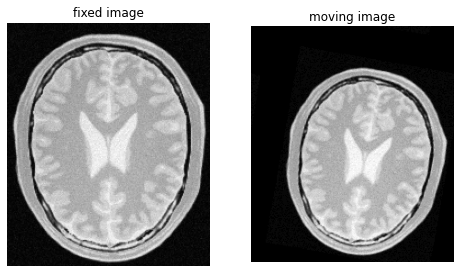

In [ ]:
fixed_im =  sitk.ReadImage('./Q1_fixed.png', sitk.sitkFloat32)
moving_im =  sitk.ReadImage('./Q1_moving.png', sitk.sitkFloat32)
fixed_array = sitk.GetArrayViewFromImage(fixed_im)
moving_array = sitk.GetArrayViewFromImage(moving_im)

plt.subplots(1,2,figsize=(8,6))  
plt.subplot(1,2,1)
plt.imshow(fixed_array, cmap='gray');
plt.title('fixed image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(moving_array,cmap='gray');
plt.title('moving image')
plt.axis('off')
plt.show()

In [ ]:
def register_img(fixed_image, moving_image, use_affine = True, metric = 'MS', optimizer = 'GD'):

    # Define initial transform ---> Affine and Centered
    transform = sitk.AffineTransform(2) if use_affine else sitk.ScaleTransform(2)
    initial_transform = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image,moving_image.GetPixelID()), 
                                                          moving_image, 
                                                          transform, 
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)

    # Define Registration method
    registration_method = sitk.ImageRegistrationMethod()

    # Set appropriate metric --> Mean Square differences or MutualInformation
    if metric == 'MS':
        registration_method.SetMetricAsMeanSquares()
    else:
        registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    
    # Define Registration method --> Brute Force
    sample_per_axis = 12
    registration_method.SetOptimizerAsExhaustive([sample_per_axis//2,0,0])
    # Utilize the scale to set the step size for each dimension
    registration_method.SetOptimizerScales([2.0*3.14/sample_per_axis, 1.0,1.0])

    # Set interpolator
    registration_method.SetInterpolator(sitk.sitkLinear)

    # Set optimizer --> Gradient Descent or RegularStepGradientDescent
    if optimizer == 'GD':
        registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, 
                                                          numberOfIterations=200, 
                                                          convergenceMinimumValue=1e-6,
                                                          convergenceWindowSize=10)
    else:
        registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=4.0, 
                                                                     minStep=0.01, 
                                                                     numberOfIterations=200,
                                                                     relaxationFactor=0.5)

    registration_method.SetOptimizerScalesFromPhysicalShift() 
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # print metric value during runnig --> Connect all of the observers so that we can perform plotting during registration
    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

    ff_img = sitk.Cast(fixed_image, sitk.sitkFloat32)
    mv_img = sitk.Cast(moving_image, sitk.sitkFloat32)
    final_transform_v1 = registration_method.Execute(ff_img, mv_img)

    # show final results
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))

    # Set resampler and interpolator
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)
    resample.SetInterpolator(sitk.sitkBSpline)  
    resample.SetTransform(final_transform_v1)

    return sitk.GetArrayFromImage(resample.Execute(moving_image))

In [ ]:
from IPython.display import clear_output
def start_plot():
    global metric_values, multires_iterations
    metric_values = []
    multires_iterations = []

def end_plot():
    global metric_values, multires_iterations
    del metric_values
    del multires_iterations
    plt.close()

# IterationEvent happens, update our data and display new figure
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    

def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

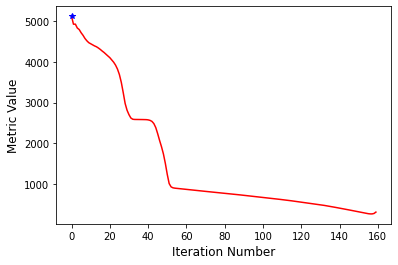

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 160.
Final metric value: 379.7428414157394


In [ ]:
registered = register_img(fixed_im, moving_im)

In [ ]:
def plot_imgs(fixed_arr, moving_arr, registered_arr):  
    fig, ((ax1, ax2), (ax1a, ax3)) = plt.subplots(2, 2, figsize = (14, 10))
    ax1.imshow(fixed_arr, cmap = 'gray', vmax = 255)
    ax1.set_title('Scan #1')
    ax2.imshow(moving_arr, cmap = 'gray', vmax = 255)
    ax2.set_title('Scan #2')
    ax1a.imshow(fixed_arr, cmap = 'gray', vmax = 255)
    ax1a.set_title('Scan #1')
    ax3.imshow(registered_arr, cmap = 'gray', vmax = 255)
    ax3.set_title('Registered Scan #2')

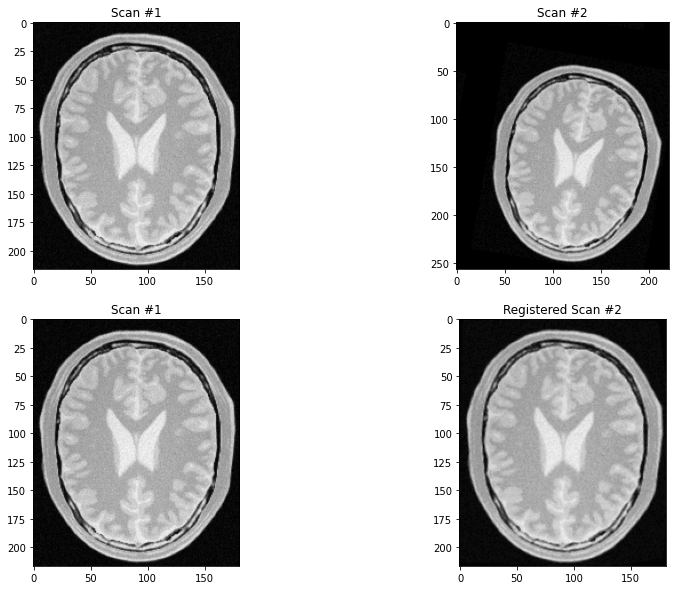

In [ ]:
plot_imgs(fixed_array, moving_array, registered)

## VoxelMorph
 For dataset we are using [FIRE dataset](https://projects.ics.forth.gr/cvrl/fire/).

In [ ]:
!pip install voxelmorph -q

     |████████████████████████████████| 75 kB 4.7 MB/s 
     |████████████████████████████████| 86 kB 7.4 MB/s 


In [ ]:
import os, sys
import glob
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
import math
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, random_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# List the image ids of each image
image_list=[".".join(f.split(".")[:-1]) for f in os.listdir('./drive/MyDrive/Q2_dataset') if os.path.isfile(os.path.join('./drive/MyDrive/Q2_dataset',f))]
im_id = []
for i, item in enumerate(image_list):
    im_id.append(item.split('_')[0])
print(im_id)

['P10', 'P12', 'P11', 'P14', 'P13', 'P10', 'P11', 'P15', 'P13', 'P12', 'P15', 'P14', 'P16', 'P16', 'P19', 'P19', 'P20', 'P20', 'A10', 'A11', 'A12', 'A11', 'A10', 'P37', 'A12', 'P37', 'P41', 'P45', 'P49', 'P46', 'P42', 'P17', 'P48', 'P40', 'P45', 'P47', 'P46', 'P49', 'P18', 'P17', 'P18', 'P43', 'P47', 'P41', 'P42', 'P44', 'P43', 'P40', 'P48', 'P44', 'P21', 'P22', 'P22', 'P21', 'P23', 'P23', 'P24', 'P24', 'A13', 'P38', 'A14', 'P25', 'P25', 'P26', 'P27', 'P26', 'P27', 'P39', 'P39', 'P28', 'P28', 'P33', 'P34', 'P34', 'P33', 'P29', 'P29', 'P38', 'A13', 'A14', 'P30', 'P31', 'P30', 'P31', 'P35', 'P36', 'P36', 'P35', 'P32', 'P32', 'S56', 'S55', 'P08', 'P09', 'P08', 'S55', 'S57', 'S56', 'S57', 'P09', 'S69', 'P06', 'S70', 'P07', 'S69', 'S71', 'P06', 'P07', 'S71', 'S70', 'S01', 'S02', 'S03', 'S01', 'S03', 'S02', 'P02', 'P02', 'S54', 'S54', 'S53', 'S53', 'S43', 'S45', 'S44', 'S45', 'S44', 'S43', 'S49', 'S48', 'S47', 'S50', 'S51', 'S47', 'S50', 'S52', 'S48', 'S49', 'S51', 'S52', 'S46', 'P01', 'P01'

In [ ]:
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm

device = 'cuda'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.backends.cudnn.deterministic = True

In [ ]:
class Dataset(Dataset):

    def __init__(self, list_IDs):
        self.list_IDs = list_IDs

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        fixed_image = torch.Tensor(cv2.resize(cv2.imread('./drive/MyDrive/Q2_dataset/' + ID + '_1.jpg', cv2.IMREAD_GRAYSCALE), (256, 256),
                                              interpolation=cv2.INTER_AREA))
        fixed_image = fixed_image = torch.unsqueeze(fixed_image, 2)
        moving_image = torch.Tensor(cv2.resize(cv2.imread('./drive/MyDrive/Q2_dataset/' + ID + '_2.jpg', cv2.IMREAD_GRAYSCALE), (256, 256),
                                               interpolation=cv2.INTER_AREA))
        moving_image = fixed_image = torch.unsqueeze(moving_image, 2)
        return moving_image, fixed_image

In [ ]:
params = {'batch_size': 1, 'shuffle': True, 'num_workers': 2, 'worker_init_fn': np.random.seed(42)}
partition = {}
partition['train'], partition['validation'] = train_test_split(im_id, test_size = 0.33, random_state=42)

#Split dataset into Train and Test
training_set = Dataset(partition['train'])
training_generator = DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'])
validation_generator = DataLoader(validation_set, **params)

In [ ]:
# configure features
inshape = next(iter(training_generator))[0].shape[1:-1] # (256,256)
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]
# VoxelMorph network for (unsupervised) nonlinear registration between two images.
vm = vxm.networks.VxmDense(
    inshape=inshape,
    nb_unet_features=[enc_nf, dec_nf],
    bidir=False,
    int_downsize=1
    )
vm.to(device)

VxmDense(
  (unet_model): Unet(
    (upsample): Upsample(scale_factor=2.0, mode=nearest)
    (downarm): ModuleList(
      (0): ConvBlock(
        (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): ConvBlock(
        (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (2): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (3): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (uparm): ModuleList(
      (0): ConvBlock(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): ConvBlock(
        (mai

In [ ]:
class Grad:

    def __init__(self, penalty='l1', loss_mult=None):
        self.penalty = penalty
        self.loss_mult = loss_mult

    def loss(self, _, y_pred):
        dy = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])
        dx = torch.abs(y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1])
        
        if self.penalty == 'l2':
            dy = dy * dy
            dx = dx * dx

        d = torch.mean(dx) + torch.mean(dy)
        grad = d / 3.0

        if self.loss_mult is not None:
            grad *= self.loss_mult
        return grad

In [ ]:
optimizer = torch.optim.Adam(vm.parameters(), lr=1e-2)
image_loss_func = vxm.losses.NCC().loss
losses = [image_loss_func]
weights = [1]

# prepare deformation loss
losses += [Grad('l2', loss_mult=1).loss]
weights += [0.001]
each_epoch_loss = []
epochs = 110
# training loops
for epoch in range(0, epochs):
    epoch_total_loss = []
    epoch_loss = []
    for batch_moving, batch_fixed in training_generator:

        batch_moving = batch_moving.to(device).float().permute(0, 3, 1, 2)
        batch_fixed = batch_fixed.to(device).float().permute(0, 3, 1, 2)

        # run inputs through the model to produce a warped image and flow field
        y_pred = vm(batch_moving, batch_fixed)

        # calculate total loss
        loss = 0
        loss_list = []
        
        for n, loss_function in enumerate(losses):
            curr_loss = loss_function(batch_fixed, y_pred[n]) * weights[n]
            loss_list.append(curr_loss.item())
            loss += curr_loss

        epoch_loss.append(loss_list)
        epoch_total_loss.append(loss.item())

        # backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # print epoch info
    epoch_info = 'Epoch %d/%d' % (epoch + 1, epochs)
    losses_info = ', '.join(['%.4e' % f for f in np.mean(epoch_loss, axis=0)])
    loss_info = 'loss: %.4e  (%s)' % (np.mean(epoch_total_loss), losses_info)
    each_epoch_loss.append(np.mean(epoch_total_loss))
    print(' - '.join((epoch_info, loss_info)), flush=True)

# final model save
vm.save(os.path.join('./', '%04d.pt' % epochs))

Epoch 1/110 - loss: 1.5090e+09  (-4.4310e+01, 1.5090e+09)
Epoch 2/110 - loss: 1.6261e+09  (0.0000e+00, 1.6261e+09)
Epoch 3/110 - loss: 9.4289e+08  (0.0000e+00, 9.4289e+08)
Epoch 4/110 - loss: 5.1829e+08  (0.0000e+00, 5.1829e+08)
Epoch 5/110 - loss: 2.7747e+08  (0.0000e+00, 2.7747e+08)
Epoch 6/110 - loss: 1.4302e+08  (0.0000e+00, 1.4302e+08)
Epoch 7/110 - loss: 7.2876e+07  (0.0000e+00, 7.2876e+07)
Epoch 8/110 - loss: 3.9895e+07  (0.0000e+00, 3.9895e+07)
Epoch 9/110 - loss: 2.6836e+07  (0.0000e+00, 2.6836e+07)
Epoch 10/110 - loss: 2.2344e+07  (0.0000e+00, 2.2344e+07)
Epoch 11/110 - loss: 2.0842e+07  (0.0000e+00, 2.0842e+07)
Epoch 12/110 - loss: 2.0110e+07  (0.0000e+00, 2.0110e+07)
Epoch 13/110 - loss: 1.9520e+07  (0.0000e+00, 1.9520e+07)
Epoch 14/110 - loss: 1.8937e+07  (0.0000e+00, 1.8937e+07)
Epoch 15/110 - loss: 1.8331e+07  (0.0000e+00, 1.8331e+07)
Epoch 16/110 - loss: 1.7703e+07  (0.0000e+00, 1.7703e+07)
Epoch 17/110 - loss: 1.7056e+07  (0.0000e+00, 1.7056e+07)
Epoch 18/110 - loss: 1

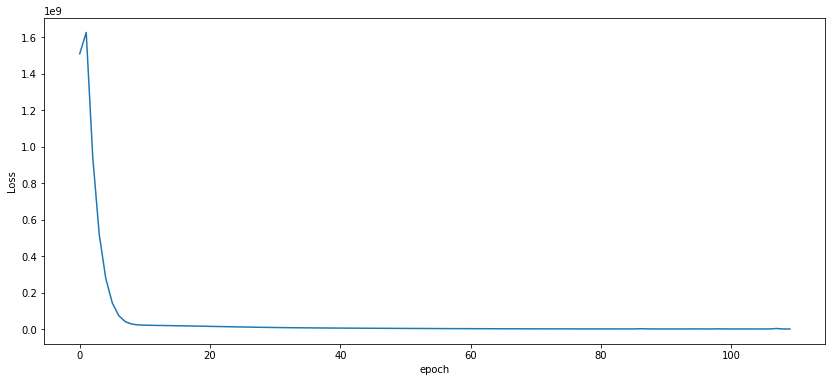

In [ ]:
plt.figure(figsize = (14, 6))
plt.plot(each_epoch_loss)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
model = vxm.networks.VxmDense.load('./0110.pt', device)
model.to(device)
model.eval()

epochtest_total_loss = []
epochtest_loss = []
for moving, fixed in validation_generator:
    # set up tensors and permute
    input_moving = moving.to(device).float().permute(0, 3, 1, 2)
    input_fixed = fixed.to(device).float().permute(0, 3, 1, 2)

    # predict
    pred = model(input_moving, input_fixed, registration=True)
    loss = 0
    loss_list = []
        
    for n, loss_function in enumerate(losses):
        curr_loss = loss_function(batch_fixed, y_pred[n]) * weights[n]
        loss_list.append(curr_loss.item())
        loss += curr_loss

    epochtest_loss.append(loss_list)
    epochtest_total_loss.append(loss.item())


losses_info = ', '.join(['%.4e' % f for f in np.mean(epochtest_loss, axis=0)])
loss_info = 'loss: %.4e  (%s)' % (np.mean(epochtest_total_loss), losses_info)
print(loss_info, flush=True)

loss: 1.0056e+04  (0.0000e+00, 1.0056e+04)
